# One Generation of Topic Data

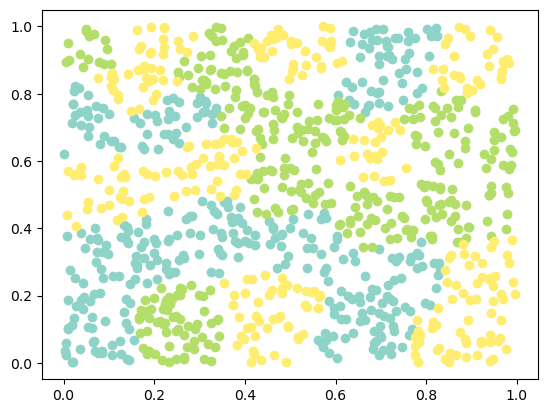

In [51]:
import sys
import os
import numpy as np
from numpy.linalg import norm, svd, solve, qr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
import networkx as nx

import scipy
from scipy.sparse import csr_matrix
from scipy.optimize import linear_sum_assignment

import cvxpy as cp
from cvxpy import Variable
from cvxpy.problems.objective import Minimize
from cvxpy.problems.problem import Problem

sys.path.append('./SpLSI/pycvxcluster/src/')
import pycvxcluster.pycvxclt

from SpLSI import generate_topic_model as gen_model
from SpLSI.utils import *
from SpLSI.spatialSVD import *
from SpLSI import splsi
#from netgraph import Graph
#from netgraph import get_sugiyama_layout

N = 100 # doc length
n = 1000 # number of nodes
p = 30 # vocab size
K = 3 # number of topics
r = 0.05 # heterogeneity parameter
m = 5 # number of neighbors to be considered in weights
phi = 0.1 # weight parameter

df, W, A, D = gen_model.generate_data(N, n, p , K, r)
gen_model.plot_scatter(df)

# MST Folds / Matrix Denoising via Iterative Convex Clustering

In [53]:
weights = gen_model.generate_weights(df, K, m, phi)
G, mst, path = generate_mst(df, weights, n)
srn, fold1, fold2 = get_folds(mst, path, n, plot_tree=False)
folds = {0:fold1, 1:fold2}

Source node is 387


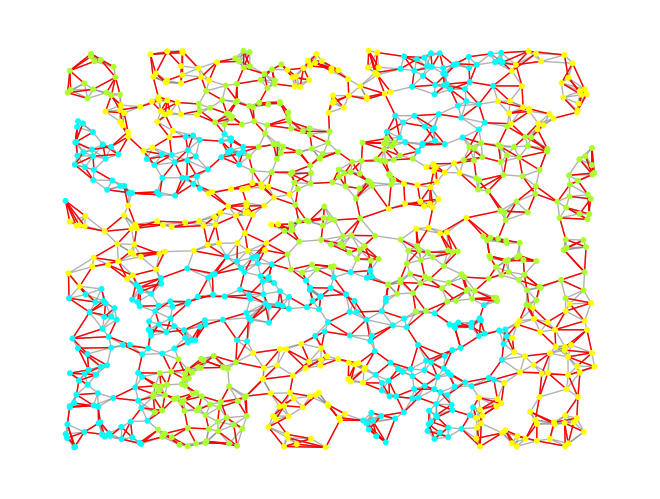

In [54]:
colors = gen_model.get_colors(df)
# Plot the random graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=False, node_size=10, node_color=colors, edge_color='gray', alpha=0.6)

# Plot the minimum spanning tree in red
nx.draw(mst, pos, with_labels=False, node_size=10, node_color=colors, edge_color='r', alpha=1)

plt.show()

# Simulations

In [55]:
def run_simul(N = 100, # doc length
              n = 1000, # number of nodes
              p = 30, # vocab size
              K = 3, # number of topics
              r = 0.05, # heterogeneity parameter
              m = 5, # number of neighbors to be considered in weights
              phi = 0.1, # weight parameter
              plot_results = True
              ):

    # generate topic data and graph
    df, W, A, D = gen_model.generate_data(N, n, p , K, r)
    weights = gen_model.generate_weights(df, K, m, phi)

    # vanilla svd
    spl_v = splsi.SpLSI(lamb_start = 0.0001,
              step_size = 1.2,
              grid_len = 50,
              method = "nonspatial")
    spl_v.fit(D, K, df, weights)

    # spatial svd (one-step)
    # spl = splsi.SpLSI(lamb_start = 0.0001,
    #          step_size = 1.2,
    #          grid_len = 50,
    #          step= "one-step")
    # spl.fit(D, K, df, weights)

    # spatial svd (two-step)
    spl_2 = splsi.SpLSI(lamb_start = 0.0001,
              step_size = 1.2,
              grid_len = 50,
              step= "two-step")
    spl_2.fit(D, K, df, weights)

    if plot_results:
        # Plot the scatter plots
        models = [spl_v, spl_2]
        names = ['Ground Truth', "VanillaSVD", "spatialSVD(2 step)"]

        print(f"Model: {names[0]}")
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        for j, ax in enumerate(axes):
            w = W[j, :]
            df[f'w{j+1}'] = w
            sns.scatterplot(x='x', y='y', hue=f'w{j+1}', data=df, palette='viridis', ax=ax)
            ax.set_title(f'Original Plot {j+1}')
        plt.tight_layout()
        plt.show()

        for i, model in enumerate(models):
            W_hat = model.W_hat
            P = get_component_mapping(W_hat.T, W)
            W_hat = W_hat @ P
            err = get_F_err(W_hat, W)
            acc = get_accuracy(df, n, W_hat)
            print(f"Model: {names[i+1]}")
            print(f"Error is {err}.")
            print(f"Accuracy is {acc}.")

            # Plot the scatter plots for the model
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            for j, ax in enumerate(axes):
                w = W_hat[:, j]
                df[f'w{j+1}'] = w
                sns.scatterplot(x='x', y='y', hue=f'w{j+1}', data=df, palette='viridis', ax=ax)
                ax.set_title(f'Plot {j+1}')
            plt.tight_layout()
            plt.show()
    
    return spl_v, spl_2

In [56]:
def run_simul2(nsim, N_vals, n=1000, p=30, K=3, r=0.05, m=5, phi=0.1):
    results = []

    for N in N_vals:
        print(f"Running simulation for N={N}...")

        for _ in range(nsim):
            # Generate topic data and graph
            df, W, A, D = gen_model.generate_data(N, n, p, K, r)
            weights = gen_model.generate_weights(df, K, m, phi)

            # Vanilla SVD
            spl_v = splsi.SpLSI(lamb_start=0.0001, step_size=1.2, grid_len=50, method="nonspatial")
            spl_v.fit(D, K, df, weights)

            # Spatial SVD (two-step)
            spl_2 = splsi.SpLSI(lamb_start=0.0001, step_size=1.2, grid_len=50, step="two-step")
            spl_2.fit(D, K, df, weights)

            # Record [err, acc] for spl_v and spl_2
            P_v = get_component_mapping(spl_v.W_hat.T, W)
            P_2 = get_component_mapping(spl_2.W_hat.T, W)

            W_hat_v = spl_v.W_hat @ P_v
            W_hat_2 = spl_2.W_hat @ P_2
            err_acc_spl_v = [get_F_err(W_hat_v, W), get_accuracy(df, n, W_hat_v)]
            err_acc_spl_2 = [get_F_err(W_hat_2, W), get_accuracy(df, n, W_hat_2)]

            results.append({
                'N': N,
                'model1' : spl_v,
                'model2' : spl_2,
                'spl_v_err': err_acc_spl_v[0],
                'spl_v_acc': err_acc_spl_v[1],
                'spl_2_err': err_acc_spl_2[0],
                'spl_2_acc': err_acc_spl_2[1],
                'spl_2_lambd': spl_2.lamd
            })
    df_grouped = pd.DataFrame(results)

    return df_grouped


In [ ]:
res = run_simul2(N_vals=[5, 10, 50, 100, 1000])

<Axes: xlabel='N', ylabel='err'>

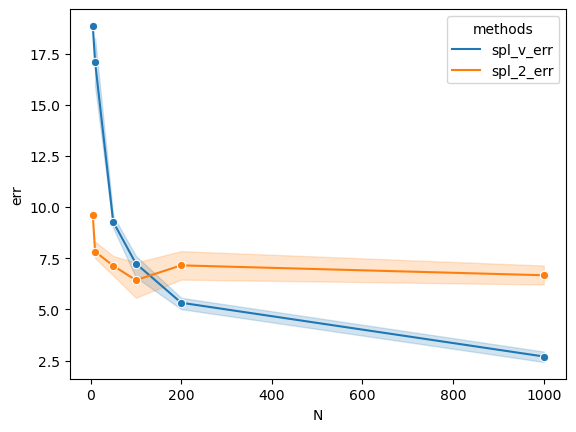

In [ ]:
df_melted = pd.melt(res[['spl_v_err','spl_2_err','N']], id_vars='N', var_name='methods', value_name='err')
sns.lineplot(x='N', y='err', hue = 'methods', data=df_melted, marker='o')

<Axes: xlabel='N', ylabel='acc'>

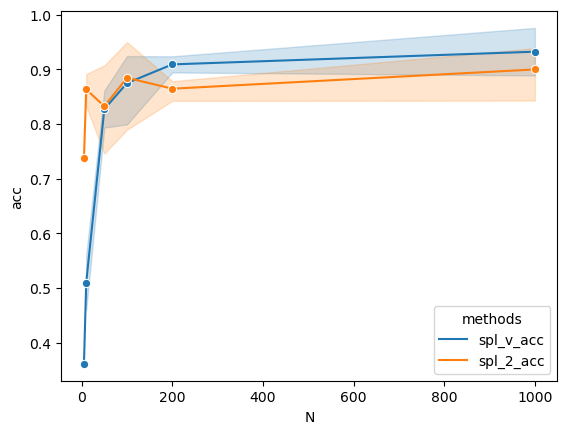

In [ ]:
df_melted = pd.melt(res[['spl_v_acc','spl_2_acc','N']], id_vars='N', var_name='methods', value_name='acc')
sns.lineplot(x='N', y='acc', hue = 'methods', data=df_melted, marker='o')

<Axes: xlabel='N', ylabel='spl_2_lambd'>

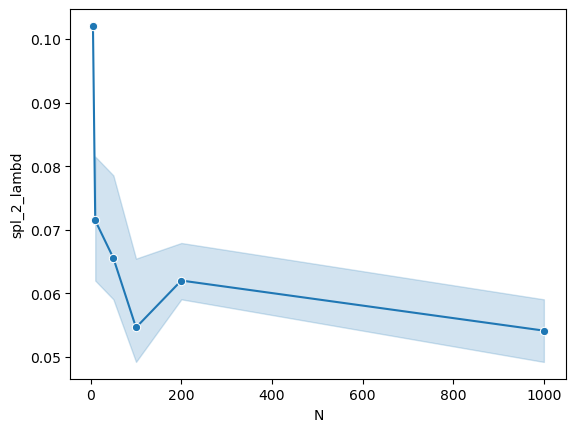

In [ ]:
sns.lineplot(x='N', y='spl_2_lambd', data=res, marker='o')

<Axes: xlabel='spl_2_lambd', ylabel='spl_2_err'>

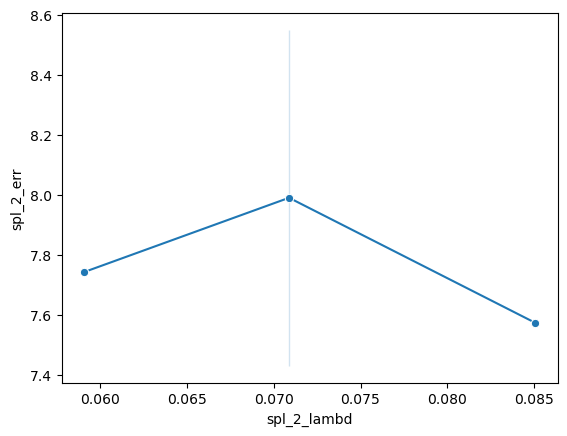

In [58]:
sns.lineplot(x='spl_2_lambd', y='spl_2_err', data=res[res['N']==10], marker='o')


<Axes: xlabel='spl_2_lambd', ylabel='spl_2_err'>

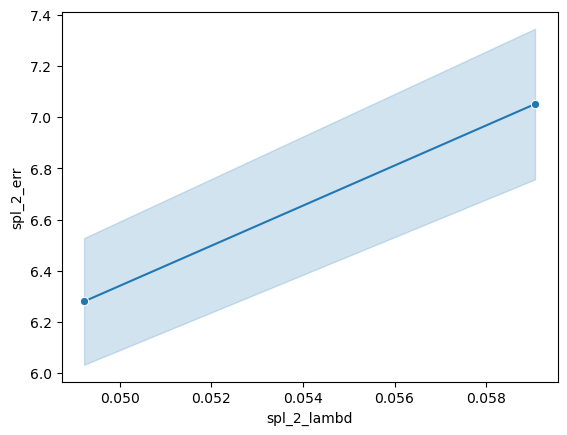

In [62]:
sns.lineplot(x='spl_2_lambd', y='spl_2_err', data=res[res['N']==1000], marker='o')